# Fairness in complex network analysis


In [1]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.linear_model import LinearRegression
from collections import Counter
import partition_igraph
#from sklearn.metrics import adjusted_mutual_info_score as AMI
import random 
import seaborn as sns
#from sklearn.metrics import roc_auc_score, roc_curve
from abcd_graph import ABCDGraph, ABCDParams
import sknetwork as skn
from sknetwork.classification import get_accuracy_score
import statsmodels.api as sm
from statsmodels.genmod import families
import json


# (1) Web developers graph


In [2]:
## setting the path to the datasets
datadir = "../Datasets/"

In [3]:
## read the GitHub developers edge list as tuples and build undirected graph
## each node index is stored in vertex attribute "id"
df = pd.read_csv(datadir + "GitHubDevelopers/musae_git_edges.csv")
G = ig.Graph.TupleList(
    [tuple(x) for x in df.values], directed=False, vertex_name_attr="id"
)

## read node class (ml or web) and save: Y=1 for ml dev. and Y=0 for web dev. 
G_attr = pd.read_csv(datadir + "GitHubDevelopers/musae_git_target.csv")

## build attribute dictionaries
_ml = dict(zip(G_attr.id, G_attr.ml_target))
G.vs["Y"] = [_ml[i] for i in G.vs["id"]]


In [4]:
## read feature 1793, set to 1 if present, 0 else
## this will be the "protected" attribute
with open(datadir + "GitHubDevelopers/musae_git_features.json") as fp:
    features = json.load(fp)
G.vs['X'] = [int(1793 in features[str(i)]) for i in G.vs['id']]


In [5]:
## build degree features from each node's neighbours
for v in range(G.vcount()):
    x = np.array([G.vs[i]['Y'] for i in G.neighbors(v)])
    G.vs[v]['web'] = sum(x==0)
    G.vs[v]['ml'] = sum(x==1)


In [6]:
## EDA - averages w.r.t. protected attribute
data = pd.DataFrame({'web':[i for i in G.vs['web']], 'ml':[i for i in G.vs['ml']], 'X':G.vs['X'], 'Y':G.vs['Y']})
data.groupby(by='X').mean()


,web,ml,Y
X,,,
0,14.894584,1.241295,0.140467
1,5.762870,6.276719,0.740846


## Build logistic regression models 

* **m1**: including the protected attribute
* **m2**: excluding the protected attribute


In [7]:
## model (m1) with protected variable X - single threshold

## first re-build data, taking 1+log for the degree-based features
data = pd.DataFrame({'web':[np.log(1+i) for i in G.vs['web']], \
                     'ml':[np.log(1+i) for i in G.vs['ml']],  \
                     'X':G.vs['X'], 'Y':G.vs['Y']})

## build model (m1)
X_m1 = sm.add_constant(data[['web', 'ml','X']])
model_m1 = sm.GLM(data['Y'], X_m1, family=sm.families.Binomial(link=families.links.Logit()))
results_m1 = model_m1.fit()

## model (m2) without protected variable X - single threshold

## build model (m2)
X_m2 = sm.add_constant(data[['web', 'ml']])
model_m2 = sm.GLM(data['Y'], X_m2, family=sm.families.Binomial(link=families.links.Logit()))
results_m2 = model_m2.fit()


## Maximize accuracy w.r.t. single threshold for both models


In [8]:
## function to compute ACCuracy, DI and SP scores
## data: contains at least 'X' (protected attribute) and 'Y' (response)
## pred: predictions for the response
def eval_pred(data, pred):
    ACC = np.mean(data['Y'] == pred)
    DI = np.abs(np.mean(pred[data['X']==1]) - np.mean(pred[data['X']==0]))
    SP = np.sum([np.abs( np.mean( pred[(data['Y']==1-i) & (data['X']==1)]==i ) - \
                         np.mean( pred[(data['Y']==1-i) & (data['X']==0)]==i ) ) for i in [0,1] ])/2
    return ACC, DI, SP


In [9]:
## threshold with best accuracy
t = np.arange(0,1,.01)
accs = [np.mean(data['Y'] == (results_m1.predict() >= i)) for i in t]
idx = np.argmax(accs)
pred = (results_m1.predict() >= t[idx])

## print resulting stats
acc, di, sp = eval_pred(data, pred)
print('\033[1m'+'model m1:','\033[0m'+f'accuracy: {acc:.5f}',f'DI: {di:.5f}',f'SP: {sp:.5f}',f'tau: {t[idx]:.2f}')

## threshold with best accuracy
accs = [np.mean(data['Y'] == (results_m2.predict() >= i)) for i in t]
idx = np.argmax(accs)
pred = (results_m2.predict() > t[idx])

## print resulting stats
acc, di, sp = eval_pred(data, pred)
print('\033[1m'+'model m2:','\033[0m'+f'accuracy: {acc:.5f}',f'DI: {di:.5f}',f'SP: {sp:.5f}',f'tau: {t[idx]:.2f}')


model m1: accuracy: 0.85093 DI: 0.82743 SP: 0.69969 tau: 0.46
model m2: accuracy: 0.84507 DI: 0.65237 SP: 0.48035 tau: 0.46


## Now with separate thresholds using model m1

Below is one-time work, we save (accuracy, DI, SP) for each value on a 100x100 grid covering thresholds for the two possible values of the protected attribute.

Next we can query/print those results as needed.


In [10]:
%%time

## one-time work - save for further queries ( < 1 min on MAC Pro 2022 )
M_acc = np.zeros(shape=(100,100))
M_di = np.zeros(shape=(100,100))
M_sp = np.zeros(shape=(100,100))
_pred = results_m1.predict() ## save the predicted probabilities from model m1

## 100x100 grid
for i in np.arange(0,100):
    for j in np.arange(0,100):
        tau = [i/100,j/100] ## the two thresholds
        pred = np.array([v >= (tau[1] if c == 1 else tau[0]) for v, c in zip(_pred, data['X'])])
        M_acc[i,j],M_di[i,j],M_sp[i,j] = eval_pred(data, pred)


CPU times: user 57.8 s, sys: 64.7 ms, total: 57.8 s
Wall time: 57.8 s


### query w.r.t. a few pairs of thresholds

In [11]:
## function to query w.r.t. a pair of thresholds
def query_results(M_acc, M_di, M_sp, th_di, th_sp):
    mask = ((M_di < th_di) & (M_sp < th_sp))
    _x, _y = np.where(mask)
    acc = M_acc[mask]
    idx = np.argmax(acc)
    return (_x[idx]/100, _y[idx]/100, acc[idx], M_di[mask][idx], M_sp[mask][idx])

## printing a few results
_bounds = [(1,1),(.65,1),(.05,1),(1,.48),(1,.05)]
for (i,j) in _bounds:
    t0,t1,acc,di,sp = query_results(M_acc, M_di, M_sp, th_di=i, th_sp=j)
    print('tau0:',t0,' tau1:',t1,f' accuracy: {acc:.5f}',f' DI: {di:.5f}',f' SP: {sp:.5f}')


tau0: 0.38  tau1: 0.54  accuracy: 0.85228  DI: 0.79882  SP: 0.65591
tau0: 0.38  tau1: 0.66  accuracy: 0.84538  DI: 0.64290  SP: 0.47491
tau0: 0.38  tau1: 0.94  accuracy: 0.76676  DI: 0.04352  SP: 0.05436
tau0: 0.38  tau1: 0.66  accuracy: 0.84538  DI: 0.64290  SP: 0.47491
tau0: 0.38  tau1: 0.89  accuracy: 0.78751  DI: 0.16809  SP: 0.04158


### plotting all grid for: accuracy, DI and SP respectively


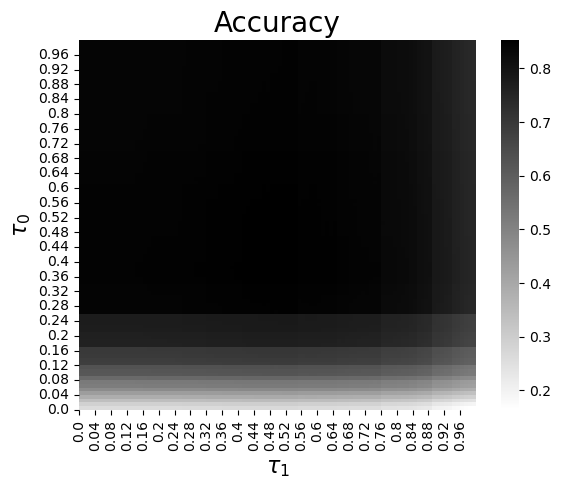

In [12]:
ax = sns.heatmap(M_acc, cmap='gray_r')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(0,1,.04))
ax.set_yticks(np.arange(0,100,4),np.arange(0,1,.04))
plt.title('Accuracy', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


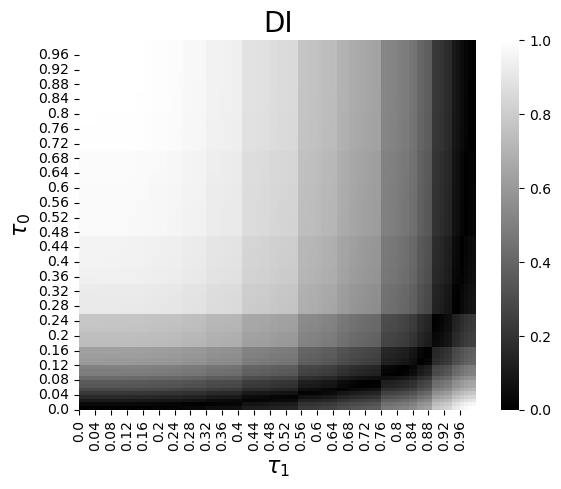

In [13]:
ax = sns.heatmap(M_di, cmap='gray')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(0,1,.04))
ax.set_yticks(np.arange(0,100,4),np.arange(0,1,.04))
plt.title('DI', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


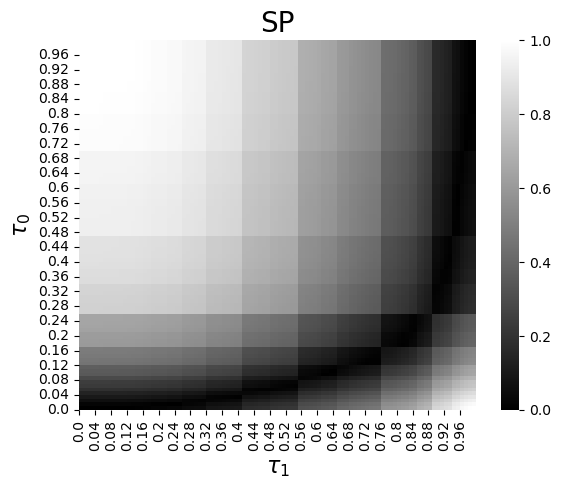

In [14]:
ax = sns.heatmap(M_sp, cmap='gray')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(0,1,.04))
ax.set_yticks(np.arange(0,100,4),np.arange(0,1,.04))
plt.title('SP', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


# (2) ABCD graph - predicting community membership vs degree

ABCD graph with one large community (size 1,000) and 10 small ones (size 100)

Variables:
* **Y** = "is a member of the large community", the response variable 
* **D** = node degree; the degree range is [30, 130)
* **X** = Protected attribute (binary) ; negatively correlated with degree

The prediction model is a simple threshold on D, we optimize w.r.t. accuracy. We demonstrate the existence of bias w.r.t. X when predicting Y. The bias can be lowered using two different thresholds for D depending on the value of X

```
(1) grid search for optimal cutoff value yields: 
tau=106, accuracy=0.73, DI=0.602, SP=0.144

(2) grid search over (tau0, tau1) with constraints DI<=.2, SP<=.05 yieds:
tau0=116, tau1=102, accuracy=0.66, DI=0.149, SP=0.035

NB: tau1 when attribute is True, so lower degrees, thus the lower cutoff.
```


In [16]:
## build ABCD graph
def build_ABCD(n=10000, gamma=2.5, delta=5, Delta=50, beta=1.5, s=100, S=1000, 
               xi=0.5, seed=321, num_outliers=0):
    zeta = np.log(Delta) / np.log(n)
    tau = np.log(S) / np.log(n)
    np.random.seed(seed)
    random.seed(seed)
    params = ABCDParams(vcount=n, gamma=gamma, min_degree=delta, max_degree=Delta, beta=beta, 
                        min_community_size=s, max_community_size=S, xi=xi, num_outliers=num_outliers)
    g = ABCDGraph(params).build()
    G = g.exporter.to_igraph()
    return G


In [33]:
## parameters
seed = 123
np.random.seed(seed)
random.seed(seed)
large_comm = 1000
small_comm = 100
n_small_comms = 10
n_total = large_comm + (n_small_comms * small_comm)
min_deg = 30
degs = np.repeat(np.arange(min_deg,min_deg+100),20)
gap = .25
xi = .1

## generate graph
c = np.concatenate( (np.array([large_comm]),np.repeat(small_comm,n_small_comms)) )
params = ABCDParams(degree_sequence=degs, community_size_sequence=c, vcount=n_total, xi=xi, num_outliers=0)
g = ABCDGraph(params).build()
G = g.exporter.to_igraph()

## build dataframe
df = pd.DataFrame()
df['Y'] = (np.array(G.vs['ground_truth_community'])==0)
df['D'] = G.degree()

## add correlated attribute - lower degrees when True
nodes = np.argsort(G.degree()) ## node from low to high degree
proba = np.linspace(.5+gap,.5-gap,n_total)
attribute = np.random.random(n_total) < proba
G.vs[nodes]['attr']  = attribute
df['X'] = G.vs['attr']
df.head()


,Y,D,X
0,True,88,True
1,True,113,True
2,True,128,False
3,True,80,True
4,True,124,False


In [34]:
## single threshold
t = np.arange(min_deg,min_deg+100)
accs = [np.mean(df['Y'] == (df['D'] >= i)) for i in t]
idx = np.argmax(accs)
pred = (df['D'] >= t[idx])
acc, di, sp = eval_pred(df, pred)
print(f'accuracy: {acc:.3f}',f'DI: {di:.5f}',f'SP: {sp:.5f}','tau:',t[idx])


accuracy: 0.730 DI: 0.19877 SP: 0.14372 tau: 107


### two thresholds

In [44]:
%%time

## one-time work - save for further queries ( < 1 min on MAC Pro 2022 )
M_acc = np.zeros(shape=(100,100))
M_di = np.zeros(shape=(100,100))
M_sp = np.zeros(shape=(100,100))

## 100x100 grid
for i in np.arange(0,100):
    for j in np.arange(0,100):
        tau = [i+min_deg,j+min_deg] ## the two thresholds
        pred = np.array([v >= (tau[1] if c == 1 else tau[0]) for v, c in zip(df['D'], df['X'])])
        M_acc[i,j],M_di[i,j],M_sp[i,j] = eval_pred(df, pred)


CPU times: user 6.5 s, sys: 27.2 ms, total: 6.53 s
Wall time: 6.55 s


In [53]:
t0, t1, acc, di, sp = query_results(M_acc, M_di, M_sp, .05, .05)
tau = ( int(100*t0+min_deg), int(100*t1+min_deg) )
print(f'accuracy: {acc:.3f}',f'DI: {di:.5f}',f'SP: {sp:.5f}','tau:',tau)


accuracy: 0.664 DI: 0.04627 SP: 0.04986 tau: (116, 103)


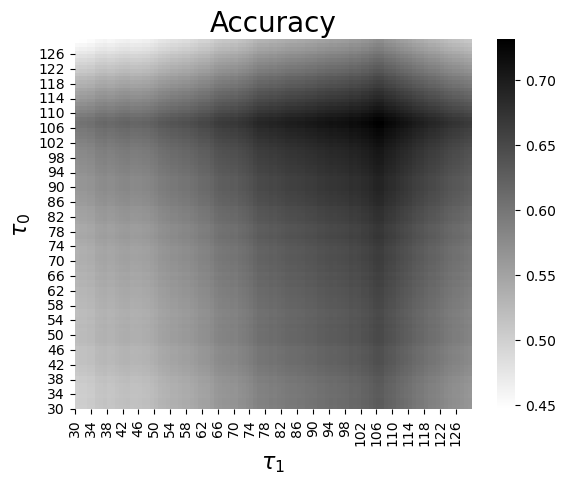

In [55]:
ax = sns.heatmap(M_acc, cmap='gray_r')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(min_deg,min_deg+100,4))
ax.set_yticks(np.arange(0,100,4),np.arange(min_deg,min_deg+100,4))
plt.title('Accuracy', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


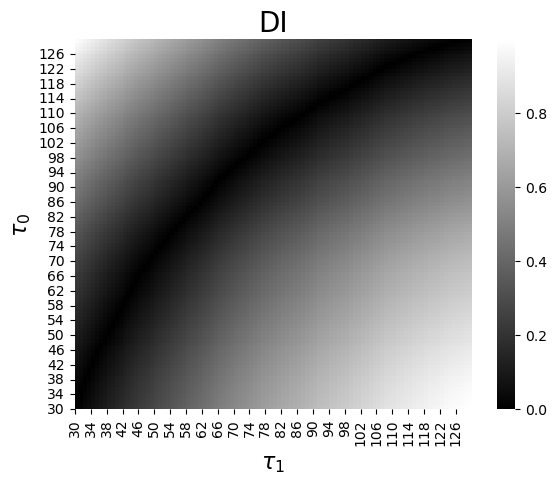

In [56]:
ax = sns.heatmap(M_di, cmap='gray')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(min_deg,min_deg+100,4))
ax.set_yticks(np.arange(0,100,4),np.arange(min_deg,min_deg+100,4))
plt.title('DI', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


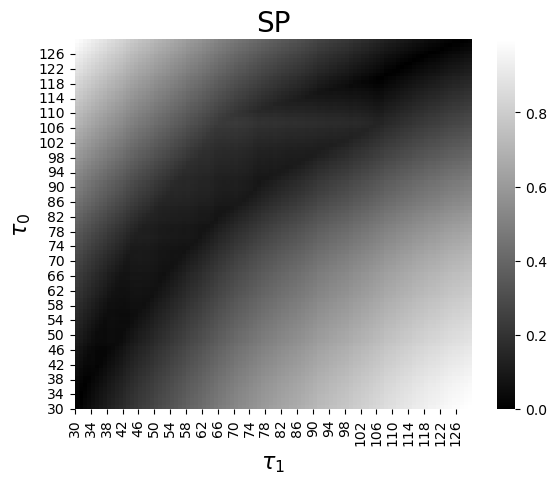

In [57]:
ax = sns.heatmap(M_sp, cmap='gray')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(min_deg,min_deg+100,4))
ax.set_yticks(np.arange(0,100,4),np.arange(min_deg,min_deg+100,4))
plt.title('SP', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


# (3) same as (2) with predictor = is outlier


In [63]:
min_deg = 3
G = build_ABCD(n=10000, gamma=2.5, delta=min_deg, Delta=min_deg+100, beta=1.5, s=100, S=5000, xi=0.33, 
               seed=123, num_outliers=5000)

In [67]:
## D = proportion of degree in most likely ECG community
G.vs['ecg'] = G.community_ecg(ens_size=32, final='leiden').membership

In [78]:
## build degree features from each node's neighbours
for v in range(G.vcount()):
    x = np.array([G.vs[i]['ecg'] for i in G.neighbors(v)])
    G.vs[v]['D'] = Counter(x).most_common()[0][1] / len(x)
    

In [108]:
## build dataframe
df = pd.DataFrame()
df['Y'] = (np.array(G.vs['ground_truth_community'])==-1)
df['D'] = G.vs['D']


In [115]:
proba = [.7,.3]
df['X'] = np.random.random(10000) < np.array([proba[int(i)] for i in df['Y']]) 


In [116]:
df.corr()

,Y,D,X
Y,1.000000,-0.349556,-0.392600
D,-0.349556,1.000000,0.139244
X,-0.392600,0.139244,1.000000


In [117]:
## single threshold
t = np.arange(0,1,.01)
accs = [np.mean(df['Y'] == (df['D'] <= i)) for i in t]
idx = np.argmax(accs)
pred = (df['D'] <= t[idx])
acc, di, sp = eval_pred(df, pred)
print(f'accuracy: {acc:.3f}',f'DI: {di:.5f}',f'SP: {sp:.5f}','tau:',t[idx])


accuracy: 0.688 DI: 0.15246 SP: 0.02031 tau: 0.5700000000000001


In [123]:
%%time

## one-time work - save for further queries ( < 1 min on MAC Pro 2022 )
M_acc = np.zeros(shape=(100,100))
M_di = np.zeros(shape=(100,100))
M_sp = np.zeros(shape=(100,100))

## 100x100 grid
for i in np.arange(0,100):
    for j in np.arange(0,100):
        tau = [i/100,j/100] ## the two thresholds
        pred = np.array([v <= (tau[1] if c == 1 else tau[0]) for v, c in zip(df['D'], df['X'])])
        M_acc[i,j],M_di[i,j],M_sp[i,j] = eval_pred(df, pred)


CPU times: user 19.5 s, sys: 41.3 ms, total: 19.5 s
Wall time: 19.5 s


In [128]:
t0, t1, acc, di, sp = query_results(M_acc, M_di, M_sp, .1, .1)
tau = ( t0,t1 )
print(f'accuracy: {acc:.3f}',f'DI: {di:.5f}',f'SP: {sp:.5f}','tau:',tau)


accuracy: 0.672 DI: 0.09671 SP: 0.04542 tau: (np.float64(0.59), np.float64(0.6))


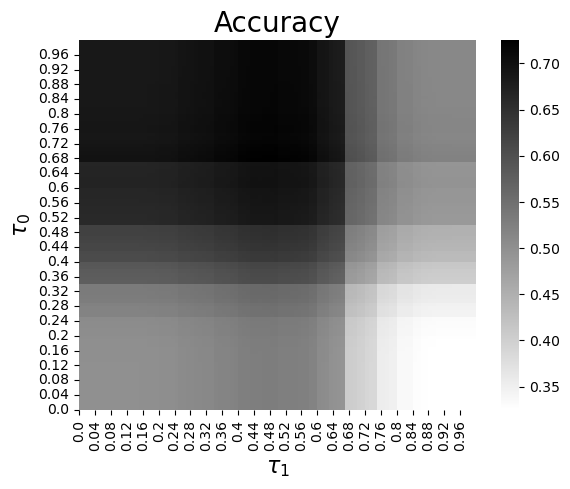

In [129]:
ax = sns.heatmap(M_acc, cmap='gray_r')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(0,1,.04))
ax.set_yticks(np.arange(0,100,4),np.arange(0,1,.04))
plt.title('Accuracy', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


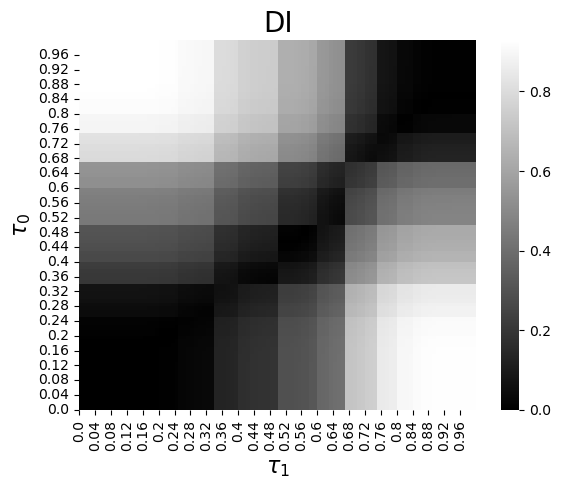

In [130]:
ax = sns.heatmap(M_di, cmap='gray')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(0,1,.04))
ax.set_yticks(np.arange(0,100,4),np.arange(0,1,.04))
plt.title('DI', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()


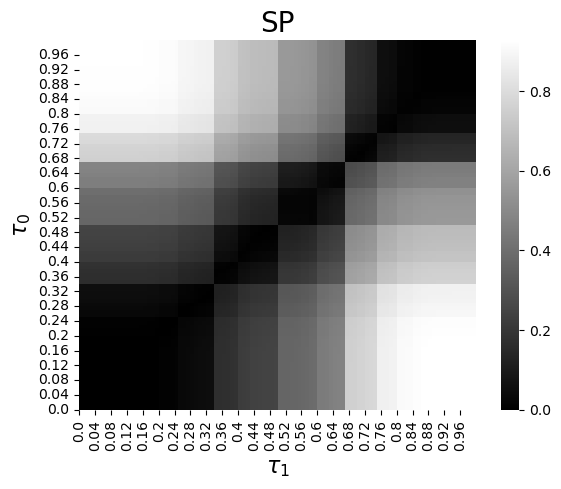

In [131]:
ax = sns.heatmap(M_sp, cmap='gray')
ax.invert_yaxis()
ax.set_xticks(np.arange(0,100,4),np.arange(0,1,.04))
ax.set_yticks(np.arange(0,100,4),np.arange(0,1,.04))
plt.title('SP', fontsize=20)
plt.ylabel(r'$\tau_0$', fontsize=16)
plt.xlabel(r'$\tau_1$', fontsize=16)
plt.show()
